In [1]:
import numpy as np 
import pandas as pd  
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
train_df = pd.read_csv('./data/emnist-balanced-train.csv', header=None)
test_df = pd.read_csv('./data/emnist-balanced-test.csv', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Data structuring

In [3]:
X_train = train_df.loc[:, 1:]
y_train = train_df.loc[:, 0]
X_test = test_df.loc[:, 1:]
y_test = test_df.loc[:, 0]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((112800, 784), (112800,), (18800, 784), (18800,))

In [4]:
label_map = pd.read_csv("./data/emnist-balanced-mapping.txt", 
                        delimiter = ' ', 
                        index_col=0, 
                        header=None).squeeze()
label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

Data visualisation and transformation

In [5]:
sample_image = X_train.iloc[42]
sample_label = y_train.iloc[42]
sample_image.shape, sample_label

((784,), 23)

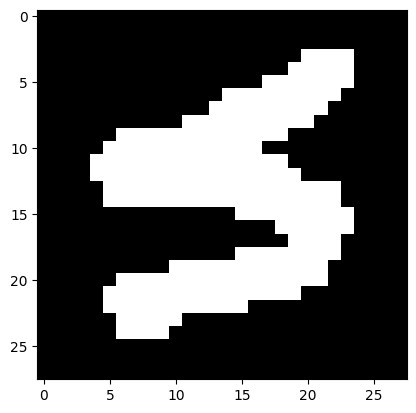

N


In [6]:
sample_image=sample_image.values.astype(np.uint8).reshape(28,28)
sample_image= cv2.threshold(sample_image, 100, 255, cv2.THRESH_BINARY)[1]
plt.imshow(sample_image, cmap=plt.cm.gray)
plt.show()
print(label_dictionary[sample_label])

In [7]:

def transformations(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    image= cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)[1]
    return image

X_train = np.apply_along_axis(transformations, 1, X_train.values.astype(np.uint8))

X_test = np.apply_along_axis(transformations, 1, X_test.values.astype(np.uint8))
X_train.shape

(112800, 28, 28)

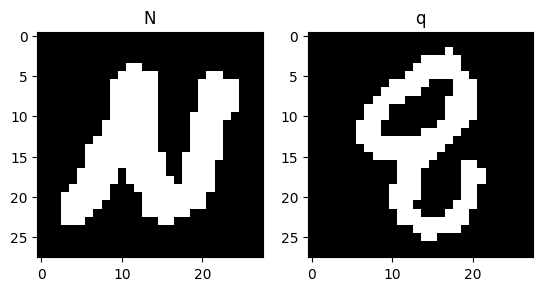

In [8]:
plt.subplot(1, 2, 1)
sample_image = X_train[42]
sample_label = y_train.iloc[42]
plt.imshow(sample_image,cmap=plt.cm.gray)
plt.title(label_dictionary[sample_label])

plt.subplot(1, 2, 2)
sample_image = X_test[42]
sample_label = y_test.iloc[42]
plt.imshow(sample_image,cmap=plt.cm.gray)
plt.title(label_dictionary[sample_label])
plt.show()

Data normalization and loading

In [9]:
X_train = X_train.astype('float32') / 255
X_train = X_train.reshape(-1,1,28,28)

X_test = X_test.astype('float32') / 255
X_test = X_test.reshape(-1,1,28,28)

X_train.shape,y_train.shape, X_test.shape,y_test.shape

((112800, 1, 28, 28), (112800,), (18800, 1, 28, 28), (18800,))

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
 
train_dataloader = DataLoader([[X_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=32)
test_dataloader = DataLoader([[X_test[i], y_test[i]] for i in range(len(y_test))], batch_size=32)

In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
test_features_batch, test_labels_batch = next(iter(test_dataloader))
print(test_features_batch.shape, test_labels_batch.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])
torch.Size([32, 1, 28, 28]) torch.Size([32])


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Model code and parameters

In [13]:
class ICR(nn.Module):
    def __init__(self):
        super(ICR,self).__init__()
        self.layers=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*6*6,512),
            nn.Dropout(0.5),
            nn.Linear(512,47)
        )
    def forward(self,X):
        out=self.layers(X)
        return out

In [14]:
model=ICR()
model.to(device)

ICR(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=2304, out_features=512, bias=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=47, bias=True)
  )
)

In [15]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

Training model

In [16]:
def train_batch(model,criterion,optimizer,train_loader,test_loader,epochs):
    for it in range(epochs):
        print(f"Epoch: {it}\n-------")
        train_loss=0
        model.train()
        for X,y in train_loader:
            y = torch.as_tensor(y, dtype=torch.long)
            X,y = X.to(device),y.to(device)
            optimizer.zero_grad()
            y_pred=model(X)
            loss=criterion(y_pred,y)
            train_loss+=loss
            loss.backward()
            optimizer.step()
        train_loss/=len(train_loader)
        test_loss=0
        test_acc=0
        model.eval()
        with torch.inference_mode():
            for X,y in test_loader:
                y = torch.as_tensor(y, dtype=torch.long)
                X,y = X.to(device),y.to(device)
                y_pred=model(X)
                loss=criterion(y_pred,y)
                test_loss+=loss
                test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_loss/=len(test_loader)
            test_acc/=len(test_loader)

        print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")





In [17]:
train_batch(model,criterion,optimizer,train_dataloader,test_dataloader,10)

Epoch: 0
-------

Train loss: 0.78902 | Test loss: 0.53317, Test acc: 82.56%

Epoch: 1
-------

Train loss: 0.52659 | Test loss: 0.48614, Test acc: 83.90%

Epoch: 2
-------

Train loss: 0.46977 | Test loss: 0.46671, Test acc: 84.73%

Epoch: 3
-------

Train loss: 0.43533 | Test loss: 0.47058, Test acc: 84.38%

Epoch: 4
-------

Train loss: 0.40688 | Test loss: 0.45528, Test acc: 84.70%

Epoch: 5
-------

Train loss: 0.38697 | Test loss: 0.45684, Test acc: 84.84%

Epoch: 6
-------

Train loss: 0.37178 | Test loss: 0.46131, Test acc: 85.07%

Epoch: 7
-------

Train loss: 0.35858 | Test loss: 0.46747, Test acc: 84.92%

Epoch: 8
-------

Train loss: 0.34557 | Test loss: 0.46445, Test acc: 84.94%

Epoch: 9
-------

Train loss: 0.33572 | Test loss: 0.47097, Test acc: 84.99%



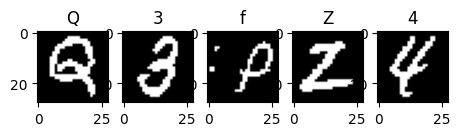

In [18]:


model.eval()
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()
random_img= torch.randint(1, 46, (7,))
for i in range(1,6):
  plt.subplot(1, 6, i)
  sample_image = X_train[random_img[i]]
  l_pred=predict_image(sample_image,model)
  plt.imshow(sample_image.numpy().reshape(28,28),cmap=plt.cm.gray)
  plt.title(label_dictionary[l_pred])

plt.show()

In [20]:
torch.save(model,'./charClassifier.pth')